Detection of Early Blight and Late Blight in potatoes early.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatoes",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)    # Size of each batch

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 0 1 0 0 1 1 2 1 1 0 2 1 0 1 1 1 1 2 1 1 1 1 1 0 0 0 2 1 1 0]


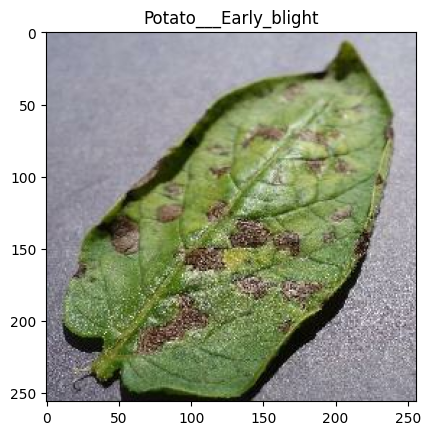

In [64]:
for image_batch, label_batch in dataset.take(1):
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

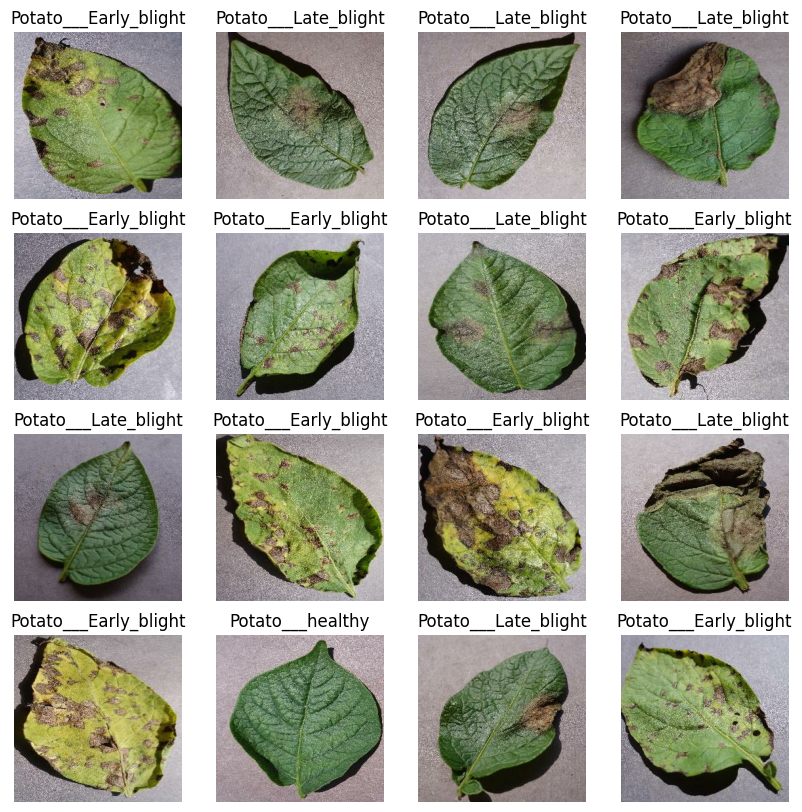

In [65]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [66]:
len(dataset)

68

Each batch has 32 images, so total length is (68*32)

In [67]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

Hence we can take 54 image samples out of 68, from each batch, for training

In [68]:
train_ds = dataset.take(54)
len(train_ds)

54

In [69]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [70]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [71]:
validation_ds = test_ds.take(7)
test_ds = test_ds.skip(6)

In [72]:
print(len(validation_ds), len(test_ds))

7 8


In [7]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    import math
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = math.ceil(val_split*ds_size)
    test_size = math.ceil(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
print(len(train_ds), len(val_ds), len(test_ds))

54 7 7


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
# Using Data Augmentation

augmented_data = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [79]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [80]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [82]:
history = model.fit(
    train_ds,
    epochs=40,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 649ms/step - accuracy: 0.4675 - loss: 0.9437 - val_accuracy: 0.6295 - val_loss: 0.8624
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 652ms/step - accuracy: 0.6828 - loss: 0.7267 - val_accuracy: 0.7723 - val_loss: 0.6973
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.7505 - loss: 0.5592 - val_accuracy: 0.8973 - val_loss: 0.3065
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 651ms/step - accuracy: 0.8047 - loss: 0.4589 - val_accuracy: 0.9241 - val_loss: 0.2326
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 661ms/step - accuracy: 0.8881 - loss: 0.2682 - val_accuracy: 0.9688 - val_loss: 0.1764
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9132 - loss: 0.2405 - val_accuracy: 0.9554 - val_loss: 0.1739
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9191 - loss: 0.2232 - val_accuracy: 0.9554 - val_loss: 0.1478
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 659ms/step - accuracy: 0.9082 - loss: 0.2144 - val_accu

In [94]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9815 - loss: 0.0428


In [95]:
scores[1]

0.9776785969734192

In [96]:
history

In [97]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [98]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [99]:
history.history['accuracy']

[0.48842594027519226,
 0.7037037014961243,
 0.7864583134651184,
 0.8275462985038757,
 0.8964120149612427,
 0.9189814925193787,
 0.9079861044883728,
 0.9207175970077515,
 0.9375,
 0.9479166865348816,
 0.9409722089767456,
 0.9392361044883728,
 0.9519675970077515,
 0.9635416865348816,
 0.9427083134651184,
 0.96875,
 0.9594907164573669,
 0.9704861044883728,
 0.9768518805503845,
 0.9803240895271301,
 0.9855324029922485,
 0.9785879850387573,
 0.9837962985038757,
 0.9774305820465088,
 0.9890046119689941,
 0.984375,
 0.9820601940155029,
 0.9890046119689941,
 0.9855324029922485,
 0.9942129850387573,
 0.9826388955116272,
 0.9861111044883728,
 0.9855324029922485,
 0.9918981194496155,
 0.9803240895271301,
 0.9884259104728699,
 0.9924768805503845,
 0.9901620149612427,
 0.9878472089767456,
 0.9890046119689941]

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

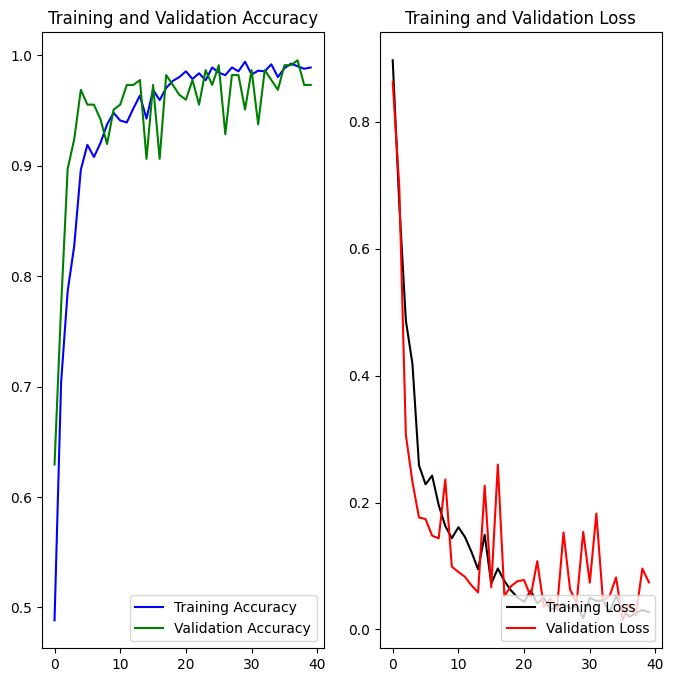

In [101]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color='blue')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='black')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color='red')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [102]:
import numpy as np
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

First image to predict
Actual Label:  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Model predicted:  Potato___healthy


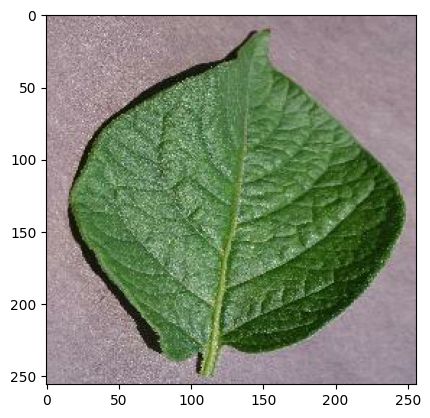

In [103]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label.numpy()])

    batch_prediction = model.predict(images_batch)
    print("Model predicted: ",class_names[np.argmax(batch_prediction[0])])

In [105]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    #Create a batch
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


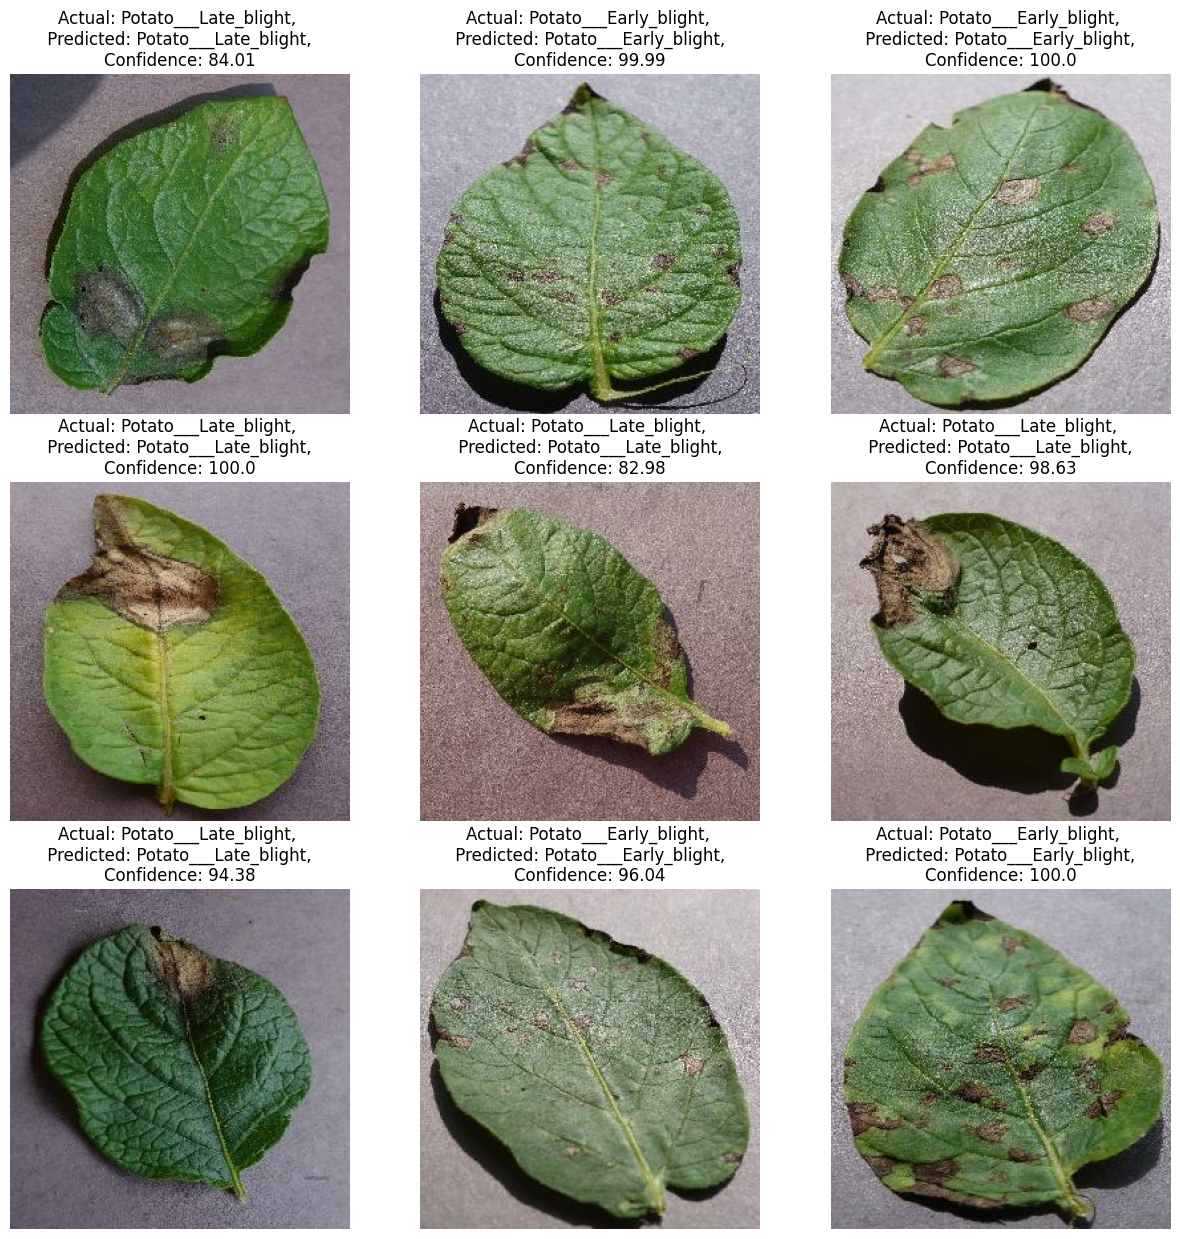

In [106]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \nConfidence: {confidence}')
        plt.axis('off')

NOW we save the models

In [109]:
model.save('C:/Users/gotze/OneDrive/Desktop/Python/Deep Learning/Project/Models/Model_1.keras')

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_2 = models.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_2.build(input_shape = input_shape)

c:\Users\gotze\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model_2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
history = model_2.fit(
    train_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 677ms/step - accuracy: 0.9856 - loss: 0.0352 - val_accuracy: 0.9866 - val_loss: 0.0409
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 697ms/step - accuracy: 0.9964 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 694ms/step - accuracy: 0.9802 - loss: 0.0534 - val_accuracy: 0.9911 - val_loss: 0.0381
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 679ms/step - accuracy: 0.9924 - loss: 0.0304 - val_accuracy: 0.9866 - val_loss: 0.0714
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 704ms/step - accuracy: 0.9916 - loss: 0.0283 - val_accuracy: 0.9777 - val_loss: 0.0781
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - accuracy: 0.9916 - loss: 0.0272 - val_accuracy: 0.9688 - val_loss: 0.0936
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 695ms/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9955 - val_loss: 0.0068
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - accuracy: 0.9996 - loss: 0.0054 - val_accu

In [21]:
scores = model_2.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 1.0000 - loss: 0.0027


In [22]:
model_2.save('C:/Users/gotze/OneDrive/Desktop/Python/Deep Learning/Project/Models/Model2_80.keras')